# GoFundMe data preparation and EDA

The following set of commands is an outline of the data preparation for the GoFundMe dataset. The imported `csv` file is the raw data that was mined from the GoFundMe website, where the only processing conducted was the tokenization of the campaign description under the `story_tokens` column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('gofund_data.csv')

## Processing raised and target fields

In order to perform any kind of calculation, the raw string that was scraped needs to undergo some preparation. In this case, the currency symbols that came with the dollar amounts for `raised` and `target` columns need to be
removed, before they can be converted into the appropriate data type.

`df[['raised', 'target']].head()`
```
raised	target
0	$695	$1,000
1	$695	$300
2	$690	$1,000
3	$690	$500
4	$690	$1,000
```

In [3]:
## Remove currency symbols and replace with ''
df['raised'] = df['raised'].str.replace('€', '')
df['target'] = df['target'].str.replace('€', '')
df['raised'] = df['raised'].str.replace('$', '')
df['target'] = df['target'].str.replace('$', '')
df['raised'] = df['raised'].str.replace(',', '')
df['target'] = df['target'].str.replace(',', '')

```
	raised	target
0	695	1000
1	695	300
2	690	1000
3	690	500
4	690	1000
```

The next step is to convert the `dtype` from `object` into `int`. Here is output before being converted. Notice the difference in `dtype`.


```
Unnamed: 0        int64
url_index        object
title            object
raised           object
target           object
m_campaign       object
created_date     object
donors          float64
shares          float64
followers       float64
scrape_date      object
c_story          object
story_tokens     object
dtype: object
```

In [4]:
# Convert dtypes
df['raised'] = df['raised'].astype(int)
df['target'] = df['target'].astype(int)
df['scrape_date'] = pd.to_datetime(df['scrape_date'])

Now, both `raised` and `target` have `int64` as `df.dtypes`
```
Unnamed: 0               int64
url_index               object
title                   object
raised                   int64
target                   int64
m_campaign              object
created_date            object
donors                 float64
shares                 float64
followers              float64
scrape_date     datetime64[ns]
c_story                 object
story_tokens            object
dtype: object
```

## Clean created_date field

The `created_date` field needs some processing prior to being converted into `datetime` objects as well. Notice how it is encoded as `dtype(object)`, compared to the `scrape_date` field. This is because new campaigns relative to the `scrape_date` were labelled as being `"Created {x} days ago"` on the GoFundMe website, whereas the `scrape_date` was directly coded as a `datetime` object during the scrape.

```
6030            2020-08-14
5631            2020-08-14
2964    Created 2 days ago
4106    Created 2 days ago
3011    Created 2 days ago
4337    Created 3 days ago
6907    Created 3 days ago
4058    Created 3 days ago
4155    Created 3 days ago
4076    Created 4 days ago
6862    Created 4 days ago
6864    Created 4 days ago
6989    Created 4 days ago
3967    Created 6 days ago
3946    Created 7 days ago
3945    Created 7 days ago
4100    Created 7 days ago
4185    Created 7 days ago
4216    Created 7 days ago
4335    Created 7 days ago
Name: created_date, dtype: object
```

In [5]:
# Regex pattern to find the beginning of a string that is a non-digit
pattern = r'(^[\D])'

# Placeholder for lists to be used later.
days_ago = []
days_index = []
days_int = []

df_tmp = df['created_date'].str.match(pattern)

A temporary `Series` is created to identify rows where the regex match returns `True`.

```
0       False
1       False
2       False
3       False
4       False
        ...  
7072    False
7073    False
7074    False
7075    False
7076    False
Name: created_date, Length: 7077, dtype: bool
```

In [6]:
def update_created_date():
    """Cleaning of 'Created x days ago' """
    
    for index, value in df_tmp.items():
        if value == True:
            days_index.append(index) # Append indices for rows that returned True

    for i in days_index:
        # Split "Created..." string in order to grab just the number of days        
        split_date = df['created_date'].loc[i].split(" ")
        days_int.append(int(split_date[1])) # Append just the number of days to list

update_created_date()

Now, the numbers from `"Created {x} days ago"` have been extracted and added to a list which can be used to calculate the actual date the campaign was created.

```
Extracted number list: 
[2, 2, 7, 7, 6, 3, 4, 7, 2, 3, 7, 7, 7, 3, 4, 4, 3, 4] 

List of indices associated with the row: 
[2964, 3011, 3945, 3946, 3967, 4058, 4076, 4100, 4106, 4155, 4185, 4216, 4335, 4337, 6862, 6864, 6907, 6989]
```

### SettingWithCopyWarning
The following line of code sets the `SettingWithCopyWarning` to `None` to silence the warning message pertaining to the issue of *chained assignments*.

In [7]:
# Fix (silence) SettingWithCopyWarning!
pd.set_option('mode.chained_assignment', None)

The next block of code is a work around for the above mentioned issue with the `SettingWithCopyWarning`. Using the proper syntax according to [this](https://www.dataquest.io/blog/settingwithcopywarning/) causes some other unintended issue with whole lists being assigned to rows. So while it is advised not to silence such *false positives*, in order to move forward with this project, a decision had to be made for a workable solution, while in search for a *purist* solution.

In [8]:
x = 0
for i in days_index:
    df['created_date'].loc[i] = str(days_int[x])
    x += 1

Now, the actual number has been extracted from the *"Created...ago"* string.

```
447              2020-08-13
2221             2020-08-13
1143             2020-08-13
3847             2020-08-13
441              2020-08-13
2563             2020-08-13
2706             2020-08-13
7060    2020-08-13 00:00:00
6963    2020-08-13 00:00:00
4251    2020-08-13 00:00:00
3935    2020-08-13 00:00:00
7034    2020-08-13 00:00:00
6030             2020-08-14
5631             2020-08-14
6031             2020-08-14
4337                      3
4155                      3
6907                      3
4058                      3
6862                      4
4076                      4
6864                      4
6989                      4
3967                      6
4185                      7
4216                      7
4100                      7
4335                      7
3946                      7
3945                      7
Name: created_date, dtype: object
```

### Convert date fields into proper datetime objects

In [9]:
from datetime import timedelta

With the `created_date` field properly formatted, we can now calculate the actual date the campaign was launched on the website, and assign that to the specific element.

In [10]:
# subtract days_ago from scrape_date
date_list = []
for i in days_index:
    df['created_date'].loc[i] = df['scrape_date'][i] - timedelta(days=int(df['created_date'][i]))

In [11]:
df['created_date'] = pd.to_datetime(df['created_date'])

We now have a properly formatted date column where EDA can be applied!

```
7060   2020-08-13
3675   2020-08-13
441    2020-08-13
3935   2020-08-13
2221   2020-08-13
7034   2020-08-13
6963   2020-08-13
447    2020-08-13
3847   2020-08-13
6031   2020-08-14
6030   2020-08-14
5631   2020-08-14
4216   2020-08-14
3946   2020-08-14
4185   2020-08-14
3945   2020-08-14
4100   2020-08-14
4335   2020-08-14
3967   2020-08-15
6989   2020-08-17
6862   2020-08-17
6864   2020-08-17
4076   2020-08-17
4337   2020-08-18
4155   2020-08-18
4058   2020-08-18
6907   2020-08-18
2964   2020-08-19
4106   2020-08-19
3011   2020-08-19
Name: created_date, dtype: datetime64[ns]

Unnamed: 0               int64
url_index               object
title                   object
raised                   int64
target                   int64
m_campaign              object
created_date    datetime64[ns]
donors                 float64
shares                 float64
followers              float64
scrape_date     datetime64[ns]
c_story                 object
story_tokens            object
dtype: object
```

In [12]:
df.head(10)

Unnamed: 0                                          url_index  \
0           0                      the-front-steps-project-yyc\n   
1           1  torchlight-covid19-fund-for-joseph-brant-hospi...   
2           2                            actions-against-abuse\n   
3           3                                  club-quarantine\n   
4           4                     wheeling-for-kids-help-phone\n   
5           5  walker-sisters-amp-family-for-covid19-response...   
6           6                      tala-and-marah039s-campaign\n   
7           7       row-run-walk-or-cycle-for-covid19-research\n   
8           8                                  bc-children039s\n   
9           9                           eqxsx-quarantining-art\n   

                                               title  raised  target  \
0                        The Front Steps Project YYC     695    1000   
1  Torchlight COVID-19 Fund for Joseph Brant Hosp...     695     300   
2                              Actions Against Abuse     690    1000   
3                             #ClubQUARANTINE Canada     690     500   
4                       Wheeling for Kids Help Phone     690    1000   
5  Walker Sisters & Family for COVID-19 Response ...     690     500   
6                          Tala and Marah's campaign     680    1000   
7      Row, run, walk or cycle for Covid-19 research     680    5000   
8                             BC Children's Hospital     680    6000   
9                                   Quarantining Art     676     100   

             m_campaign created_date  donors  shares  followers scrape_date  \
0     animal-fundraiser   2020-03-27    16.0    21.0       14.0  2020-08-21   
1    medical-fundraiser   2020-05-04    10.0     0.0       10.0  2020-08-21   
2  volunteer-fundraiser   2020-07-04    28.0    70.0       27.0  2020-08-21   
3  emergency-fundraiser   2020-03-20    16.0     0.0       16.0  2020-08-21   
4    medical-fundraiser   2020-04-15    12.0     0.0       12.0  2020-08-21   
5  emergency-fundraiser   2020-04-08     8.0     0.0        1.0  2020-08-21   
6  volunteer-fundraiser   2020-03-25    14.0    81.0       14.0  2020-08-21   
7    medical-fundraiser   2020-04-29    17.0    11.0       17.0  2020-08-21   
8  volunteer-fundraiser   2020-03-01     7.0     0.0        7.0  2020-08-21   
9    medical-fundraiser   2020-05-19    12.0     0.0       12.0  2020-08-21   

                                             c_story  \
0  It feels like the world has stopped, doesn’t i...   
1  Torchlight is a community-based gaming store l...   
2  Want to join me and my team in making a differ...   
3  We are living in an unprecedented time in hist...   
4  with the emergence of COVID-19 we are in uncer...   
5  Let's join together as a family to raise money...   
6  Do you want to join me in making a difference?...   
7  Want to join me in making a difference? I'm ra...   
8  Want to join me in making a difference? The Yo...   
9  Hi everyone! I am doing a special fundraiser f...   

                                        story_tokens  
0  ['It feels like the world has stopped, doesn’t...  
1  ['Torchlight is a community-based gaming store...  
2  ['Want to join me and my team in making a diff...  
3  ['We are living in an unprecedented time in hi...  
4  ['with the emergence of COVID-19 we are in unc...  
5  ["Let's join together as a family to raise mon...  
6  ['Do you want to join me in making a differenc...  
7  ['Want to join me in making a difference?', "I...  
8  ['Want to join me in making a difference?', "T...  
9  ['Hi everyone!', 'I am doing a special fundrai...

## Descriptive Statistics for the GoFundMe dataset

Now that all the variable have been properly formatted, we can perform some exploratory data analysis on the dataset!

Interestingly enough, we can actually say that almost all followers were actually donating to their chosen campaign!

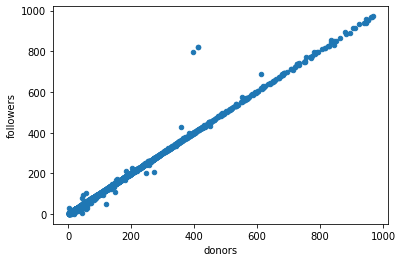

In [13]:
df.plot.scatter(x='donors', y='followers')

### Amount Raised by Category

Combining all the total amount raised for each category, we then sort them according to the category with the highest dollar amount raised so far...

In [14]:
df_rc = pd.melt(df, id_vars=['m_campaign'], value_vars='raised', value_name='Amount Raised', var_name='Category')
df_rc = df_rc.groupby('m_campaign').sum()
df_rc.rename_axis('Category', inplace=True)
pd.options.display.float_format = '{:,.2f}'.format
df_rc = df_rc.sort_values('Amount Raised', ascending=False)
df_rc

Amount Raised
Category                              
competition-fundraiser      1001113846
newlywed-fundraiser          266540890
travel-fundraiser             97447367
medical-fundraiser            18654746
emergency-fundraiser          11709363
memorial-fundraiser           11515473
community-fundraiser           6693148
family-fundraiser              4938286
animal-fundraiser              2492360
education-fundraiser           2472464
volunteer-fundraiser           2008740
business-fundraiser            1652920
creative-fundraiser            1533067
sports-fundraiser              1157413
wishes-fundraiser               719918
faith-fundraiser                690886
event-fundraiser                431120
discover                        310154
environment-fundraising          15843

And we can see how skewed the data is by the top 5 campaign categories.

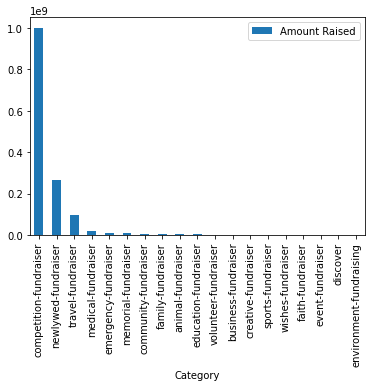

In [15]:
df_rc.plot(kind='bar')

### Number of Campaigns per Category

In [16]:
df_cat = df[['m_campaign', 'title']]
df_cat = df_cat.groupby('m_campaign').count()
df_cat.drop(index='discover', inplace=True)
df_cat.rename_axis('Category', inplace=True)
df_cat = df_cat.rename(columns={'title': 'Number of Campaigns'})
df_cat = df_cat.sort_values(by='Number of Campaigns', ascending=False)
df_cat

Number of Campaigns
Category                                    
medical-fundraiser                       584
community-fundraiser                     574
volunteer-fundraiser                     458
emergency-fundraiser                     450
family-fundraiser                        437
faith-fundraiser                         434
education-fundraiser                     432
creative-fundraiser                      427
animal-fundraiser                        410
memorial-fundraiser                      408
sports-fundraiser                        382
event-fundraiser                         378
business-fundraiser                      377
travel-fundraiser                        369
wishes-fundraiser                        341
competition-fundraiser                   338
newlywed-fundraiser                      191
environment-fundraising                    9

Remember our top 5 campaign category in terms of dollar amount raised...
```
competition-fundraiser	1001113846
newlywed-fundraiser	266540890
travel-fundraiser	97447367
medical-fundraiser	18654746
emergency-fundraiser	11709363
```
As it turned out, we have a slightly different picture when the data it pitted against the number of campaigns *within* each category...

```
medical-fundraiser	584
community-fundraiser	574
volunteer-fundraiser	458
emergency-fundraiser	450
family-fundraiser	437
```

Objectively, people who donate to competitive causes are able to raise higher dollar amounts judging by the ratio of total amount raised versus total number of campaigns in each category.

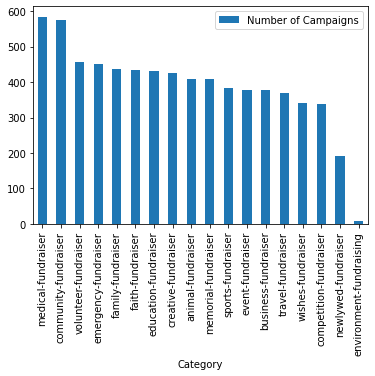

In [17]:
df_cat.plot.bar()

### Visualize Amount Raised vs Number of Donors

In [35]:
df_rv = pd.DataFrame(df[['m_campaign', 'donors', 'raised']])
df_rv = df_rv.groupby('m_campaign').mean()
df_rv.drop(index='discover', inplace=True)
df_rv.sort_values(by='raised', ascending=False)

donors       raised
m_campaign                                  
competition-fundraiser    63.36 2,961,875.28
newlywed-fundraiser       17.96 1,395,502.04
travel-fundraiser         64.64   264,085.01
medical-fundraiser       201.33    31,943.06
memorial-fundraiser      218.95    28,224.20
emergency-fundraiser     190.52    26,020.81
community-fundraiser      84.28    11,660.54
family-fundraiser        102.96    11,300.43
animal-fundraiser         80.82     6,078.93
education-fundraiser      51.66     5,723.30
volunteer-fundraiser      38.23     4,385.90
business-fundraiser       52.92     4,384.40
creative-fundraiser       31.04     3,590.32
sports-fundraiser         33.72     3,029.88
wishes-fundraiser         15.98     2,111.20
environment-fundraising   20.29     1,760.33
faith-fundraiser          19.70     1,591.90
event-fundraiser          18.05     1,140.53